In [1]:
import os
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"

import cv2 
import sys
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch as t
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"]="1"
sys.path.append("..")
from src import *

2024-07-24 14:43:30.138419: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 14:43:30.182191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 14:43:31.060564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
config_path = "../config.json"
with open(config_path, "r") as f:
    configs = json.load(f)
    dataset_statistics = configs["dataset_statistics"]
    checkpoint_path = configs["model_weights"]
    pretrained_model_path = configs["pretrained_model_path"]
with open(os.path.join(configs["dataset_statistics"], "melanoma_means.json"), "r") as f:
    markers = json.load(f).keys()

In [5]:
data = get_data_csv(high_quality_only=True, pfs=True, config_path=config_path)
data = data.reset_index().drop("index", axis=1)

In [7]:
rois = [os.path.splitext(f)[0][7:] for f in os.listdir("../data/ROIs/ground_truth_ROI/filled") if "filled" in f]
data = data[data["file_path"].isin(rois)]

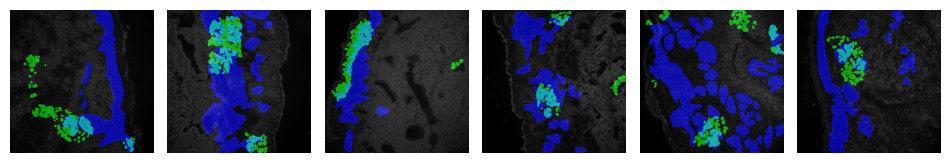

In [10]:
f, axs = plt.subplots(1, 6, figsize=(12, 7))

binaries = list()
quantile = 0.9
data_path = "/data_nfs/datasets/melc/melanoma"
for i, filepath in enumerate(np.array(data["file_path"])[[0, 1, 2, 5, 11, 13]]):
    ax = axs[i]

    roi = cv2.imread(f"../data/ROIs/ground_truth_ROI/filled/filled_{filepath}.tif", cv2.IMREAD_GRAYSCALE)
    roi = cv2.resize(roi, (512, 512))
   
    segmented = os.path.join(base, "datasets/melc/melanoma/", "segmented", f'{filepath}_cells.npy')
    with open(segmented, "rb") as openfile:
        seg_file = np.load(openfile)
        
    gc = binary = np.isin(seg_file, get_roi_cells(configs["PFS_ROIs"], filepath)[1:])
    gc = cv2.resize(gc.astype(np.uint8) * 255, (512, 512), interpolation=cv2.INTER_AREA)

    phase = cv2.imread([os.path.join(data_path, "processed", filepath, f) for f in os.listdir(os.path.join(data_path, "processed", filepath)) if "phase.tif" in f.lower()][0])
    phase = cv2.resize(phase, (512, 512), interpolation=cv2.INTER_AREA)
    ax.imshow(rgb_on_background(r=-1, g=gc, b=roi, background=phase))
    ax.axis("off")

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig("../result_plots/model_rois.png", bbox_inches="tight")